### 6. Decision Trees and Ensemble Learning

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

#### 6.2 Data Cleaning and Preparation

In [3]:
df = pd.read_csv(r'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv')

In [4]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [5]:
df.columns = df.columns.str.lower()

In [6]:
status_values =  {1: 'ok', 2: 'default', 0: 'unknown'}
df.status = df.status.map({1: 'ok', 2: 'default', 0: 'unknown'})

In [7]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [8]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [9]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [10]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [11]:
df = df.query('status != "unk"').reset_index(drop=True)

In [12]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [15]:
del df_train['status']
del df_val['status']
del df_test['status']

#### 6.3 Decision Trees

In [16]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6_000:
            return 'ok' 
        else:
            return 'default'

In [17]:
xi = df_train.iloc[0].to_dict()

In [18]:
assess_risk(xi)

'ok'

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer

In [20]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [21]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [22]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [23]:
val_dicts = df_val.fillna(0).to_dict(orient='records')

In [24]:
X_val = dv.transform(val_dicts)

In [25]:
y_pred = dt.predict_proba(X_val)[:,1]

In [26]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, y_pred)

0.6570044129099247

In [27]:
# retrain with restricted depth
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.6876073869887143

In [28]:
from sklearn.tree import export_text

print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1



#### 6.4 Decision Tree Learning Algorithm

In [29]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [30]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [31]:
Ts = [2000, 3000, 4000, 5000, 8000]

for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]

    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))
    

2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64
3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64
4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64
5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64


In [32]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [33]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [34]:
thresholds = {
    'assets' : [2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 5000]
}

In [35]:
for feature, Ts in thresholds.items():
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

    print("###################")
        

assets
2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64
3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64
4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64
5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64
###################
debt
500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64
1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64
5000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status


Series([], Name: proportion, dtype: float64)
###################


#### 6.5 Decision Trees Parameter Tuning

In [36]:
for d in [1,2,3,4,5,6,10,15,20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print(d, auc)

1 0.6131750701491985
2 0.6876073869887143
3 0.763427236430611
4 0.77933905239867
5 0.7834892891135861
6 0.7757203426494764
10 0.7052064920456371
15 0.6820974301289262
20 0.6644797834336642
None 0.6589976390313848


In [37]:
scores = []

for d in [4, 5, 6]:
    for s in [1,2,5,10,15,20,100,200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, s, auc))

In [38]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,max_depth,min_samples_leaf,auc
0,4,1,0.779339
1,4,2,0.779339
2,4,5,0.779339
3,4,10,0.773832
4,4,15,0.770767
5,4,20,0.783517
6,4,100,0.766987
7,4,200,0.764929
8,4,500,0.671368
9,5,1,0.783647


In [39]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values = ['auc'])

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

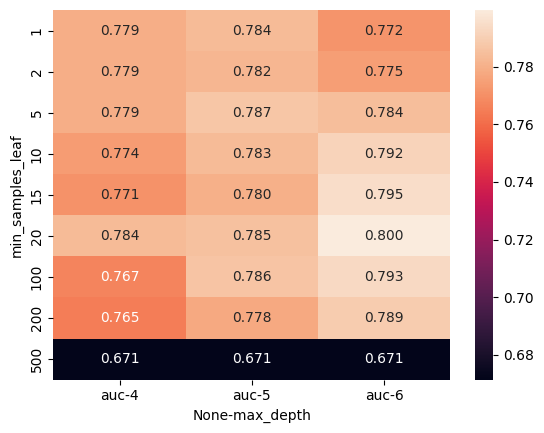

In [40]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [41]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

#### 6.6 Ensembles and Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [50]:
y_pred = rf.predict_proba(X_val)[:, 1]

In [51]:
roc_auc_score(y_val, y_pred)

0.8135545556805399

In [52]:

rf.predict_proba(X_val[[0]])

array([[1., 0.]])

In [56]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append((n,auc))


In [57]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

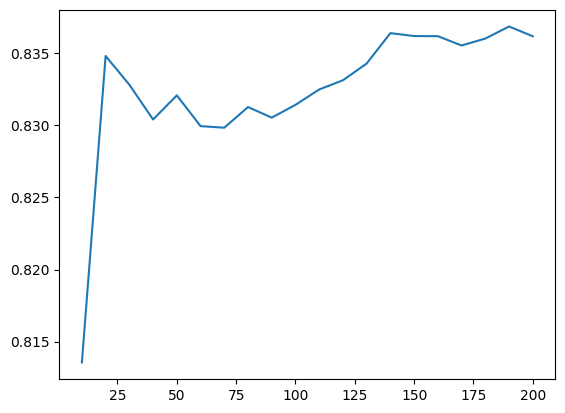

In [58]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [59]:
scores = []

for d in [5,10,15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, random_state=1, max_depth=d)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append((n,d,auc))


In [60]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'max_depth', 'auc']) 

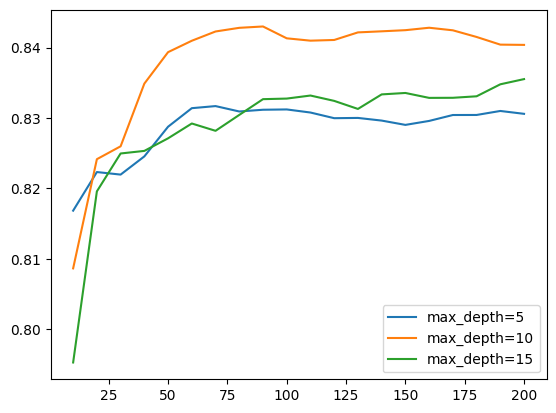

In [64]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label = f'max_depth={d}' )

plt.legend()

In [65]:
max_depth = 10

In [71]:
scores = []

for s in [1, 3 , 5, 10 , 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, random_state=1, max_depth=max_depth, min_samples_leaf=s)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append((s,n,auc))


In [72]:
df_scores = pd.DataFrame(scores, columns=['min_samples_leaf', 'n_estimators', 'auc']) 

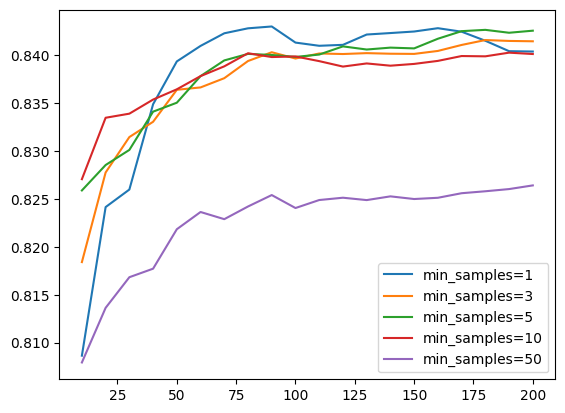

In [73]:
for s in [1, 3 , 5, 10 , 50]:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc, label = f'min_samples={s}' )

plt.legend()

In [74]:
rf = RandomForestClassifier(n_estimators = n, max_depth=max_depth, min_samples_leaf=3, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       n_jobs=-1, random_state=1)

#### 6.7 Gradient Boosting and XGBoost

In [82]:
import xgboost as xgb

In [91]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names = list(features))
dval = xgb.DMatrix(X_val, label=y_val, feature_names = list(features))

In [92]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthreads': 8,
    'seed': 1,
    'verbosity': 1,

}

model = xgb.train(xgb_params, dtrain, num_boost_round=200)

c:\Users\khanm375\Documents\ml_zoom\venv\lib\site-packages\xgboost\core.py:160: UserWarning: [18:07:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "nthreads" } are not used.

  warnings.warn(smsg, UserWarning)


In [93]:
y_pred = model.predict(dval)

In [94]:
roc_auc_score(y_val, y_pred)

0.8127912582355779

In [95]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [99]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthreads': 8,
    'seed': 1,
    'verbosity': 1,

}

model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist, verbose_eval=5)

In [100]:
s = output.stdout

In [102]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [103]:
df_score = parse_xgb_output(output)

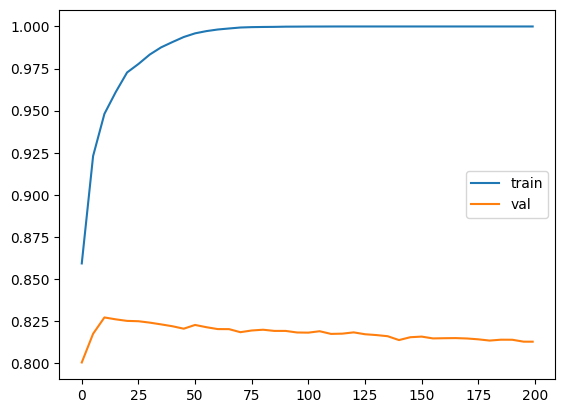

In [104]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

#### 6.8 XGBoost Parameter Tuning

In [161]:
scores = {}

In [168]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 13,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthreads': 8,
    'seed': 1,
    'verbosity': 1,

}

model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist, verbose_eval=5)

In [169]:
key = f"min_child_weight={xgb_params['min_child_weight']}"
scores[key] = parse_xgb_output(output)

In [170]:
scores.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=10', 'min_child_weight=13'])

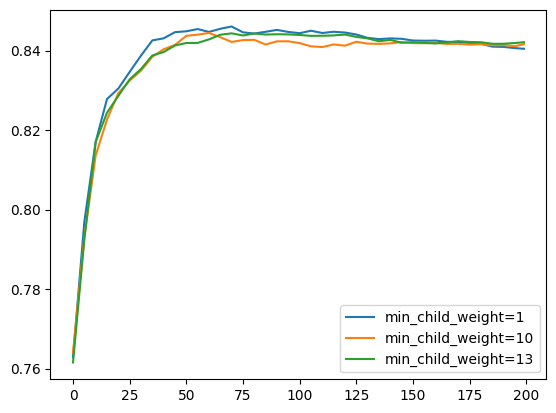

In [172]:
for eta in ['min_child_weight=1', 'min_child_weight=10', 'min_child_weight=13']:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

#plt.ylim(0.8, 0.84)
plt.legend()

In [174]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight':30,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthreads': 8,
    'seed': 1,
    'verbosity': 1,

}

model = xgb.train(xgb_params, dtrain, num_boost_round=175, evals=watchlist, verbose_eval=5)

#### 6.9 Selecting the Final Model

In [177]:
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 15,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [176]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [178]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8473899553764571

In [179]:
df_full_train = df_full_train.reset_index(drop=True)

In [180]:
y_full_train = (df_full_train.status == 'default').astype(int).values

In [181]:
del df_full_train['status']

In [182]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [183]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=list(dv.get_feature_names_out()))

dtest = xgb.DMatrix(X_test, feature_names=list(dv.get_feature_names_out()))

In [184]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight':30,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthreads': 8,
    'seed': 1,
    'verbosity': 1,

}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175, verbose_eval=5)

In [185]:
y_pred = model.predict(dtest)

In [186]:
roc_auc_score(y_test, y_pred)

0.8383796124744497